## 概述

现代数据天气预报(numerical weather prediction, NWP)可以追溯到1920年，其基于物理原理，整合了几代气象学者的成果经验，是各国气象部门所采用主流的天气预报方法。其中来自欧洲中期天气预报中心(ECMWF)的高分辨率综合系统模型(IFS)表现效果最佳.

直到2022年英伟达研发了一种基于傅里叶神经网络的预测模型FourCastNet，它能以0.25°的分辨率生成全球关键天气指标的预测，这相当于赤道附近约30×30km的空间分辨率和720×1440像素的权重网格大小，与IFS系统一致。这项成果使得AI气象模型首次与传统的物理模型IFS进行直接比较。更多信息可参考：["FourCastNet: A Global Data-driven High-resolution Weather Model using Adaptive Fourier Neural Operators."](https://arxiv.org/pdf/2202.11214.pdf)

但是基于傅里叶神经算子(Fourier Neural Operator, FNO)构建的预测模型FourCastnet在预测中长期天气时，变得不够准确和缺乏可解释性。ViT-KNO充分利用Vision Transformer结构和Koopman理论，学习Koopman Operator去预测非线性动力学系统，通过在线性结构中嵌入复杂的动力学去约束重建过程，ViT-KNO能够捕获复杂的非线性行为，同时保持模型轻量级和计算有效性。ViT-KNO有清晰的数学理论支撑，很好的克服了同类方法在数学和物理上可解释性和理论依据不足的问题。更多信息可参考：["KoopmanLab: machine learning for solving complex physics equations."](https://arxiv.org/pdf/2301.01104.pdf)

## 问题描述

本案例将ViT-KNO应用于气象领域，进一步提升了天气预报的准确度，为预防极端自然灾害提供了新的方案。

## 技术路径

MindEarth求解该问题的具体流程如下：

1. 模型构建
2. 损失函数
3. 模型训练
4. 模型验证和可视化

## ViT-KNO

ViT-KNO模型构架如下图所示，主要包含两个分支，上路分支负责结果预测，由encoder模块，Koopman Layer模块，decoder模块组成，其中Koopman Layer模块结构如虚线框所示，可重复堆叠；下路分支由encoder模块，decoder模块组成，负责输入信息的重构。

![ViT-KNO](./images/vit_kno.png "Model")

模型的训练流程如下

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from mindspore import context, Model
from mindspore import dtype as mstype
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore.train.loss_scale_manager import DynamicLossScaleManager

from mindearth.cell import ViTKNO
from mindearth.utils import load_yaml_config, create_logger
from mindearth.data import Dataset, Era5Data, FEATURE_DICT, SIZE_DICT
from mindearth.module import Trainer

from src.callback import EvaluateCallBack, InferenceModule, Lploss, CustomWithLossCell

[WARNING] ME(76108:139788375462144,MainProcess):2023-08-21-07:19:39.143.562 [/data1/lbk/MindEarthtmp/applications/medium-range/koopman_vit/mindearth/__init__.py:59] Current version of MindSpore is not compatible with MindEarth. Some functions might not work or even raise error. Please install MindSpore version >= 1.8.1 For more details about dependency setting, please check the instructions at MindSpore official website https://www.mindspore.cn/install or check the README.md at https://gitee.com/mindspore/mindscience
[WARNING] ME(76108:139788375462144,MainProcess):2023-08-21-07:19:39.144.750 [/data1/lbk/MindEarthtmp/applications/medium-range/koopman_vit/mindearth/__init__.py:67] Please pay attention to the above warning, countdown: 3
[WARNING] ME(76108:139788375462144,MainProcess):2023-08-21-07:19:40.146.445 [/data1/lbk/MindEarthtmp/applications/medium-range/koopman_vit/mindearth/__init__.py:67] Please pay attention to the above warning, countdown: 2
[WARNING] ME(76108:139788375462144,

 `src` 文件可以从 `MindEarth/applications/koopman-vit/src`下载.

In [2]:
context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", device_id=1)

In [11]:
config = load_yaml_config('./vit_kno.yaml')
config['model']['data_sink'] = True

config['train']['distribute'] = False
config['train']['amp_level'] = 'O2'

config['data']['num_workers'] = 1
config['data']['grid_resolution'] = 1.4
config['data']['h_size'], config['data']['w_size'] = SIZE_DICT[1.4]

config['optimizer']['epochs'] = 10
config['optimizer']['finetune_epochs'] = 1
config['optimizer']['warmup_epochs'] = 1
config['optimizer']['initial_lr'] = 0.0001

config['summary']["valid_frequency"] = 10
config['summary']["summary_dir"] = './summary'

logger = create_logger(path=os.path.join(config['summary']["summary_dir"], "results.log"))

model、data和optimizer的参数可以通过 `config`获取.

## 模型构建

模型的计算流程：

- 分支一 （Prediction）

    1. 输入数据首先经过Encoder模块实现输入向量的高维映射。
    2. 将Encoder的输出结果作为Koopman模块的输入，进行频域信息的非线性变换。
    3. Decoder模块对Koopman的输出数据进行映射，得到最终预测输出

- 分支二 （Reconstruction）

    1. 输入数据首先经过Encoder模块实现输入向量的高维映射。
    2. 将Encoder模块的输出作为Decoder模块的输入，实现对输入数据的重建。

In [4]:
data_params = config["data"]
model_params = config["model"]
compute_type = mstype.float32

model = ViTKNO(image_size=(data_params["h_size"], data_params["w_size"]),
               in_channels=data_params["feature_dims"],
               out_channels=data_params["feature_dims"],
               patch_size=data_params["patch_size"],
               encoder_depths=model_params["encoder_depth"],
               encoder_embed_dims=model_params["encoder_embed_dim"],
               mlp_ratio=model_params["mlp_ratio"],
               dropout_rate=model_params["dropout_rate"],
               num_blocks=model_params["num_blocks"],
               high_freq=True,
               encoder_network=model_params["encoder_network"],
               compute_dtype=compute_type)

## 损失函数

ViT-KNO使用多loss的训练方法，包括Prediction loss，Reconstruction loss，两者均基于mean squared error。

In [8]:
loss_fn = Lploss()
loss_net = CustomWithLossCell(model, loss_fn)

## 模型训练

模型训练阶段继承了Trainer类，同时重写了_get_callback，_get_solver两个成员函数，以便于能在训练阶段执行测试验证；

In [9]:
class ViTKNOEra5Data(Era5Data):
    def _patch(self, x, img_size, patch_size, output_dims):
        """ Partition the data into patches. """
        if self.run_mode == 'valid' or self.run_mode == 'test':
            x = x.transpose(1, 0, 2, 3)
        return x

class ViTKNOTrainer(Trainer):
    def __init__(self, config, model, loss_fn, logger):
        super(ViTKNOTrainer, self).__init__(config, model, loss_fn, logger)
        self.pred_cb = self._get_callback()

    def _get_dataset(self):
        """
        Get train and valid dataset.

        Returns:
            Dataset, train dataset.
            Dataset, valid dataset.
        """
        train_dataset_generator = ViTKNOEra5Data(data_params=self.data_params, run_mode='train')
        valid_dataset_generator = ViTKNOEra5Data(data_params=self.data_params, run_mode='valid')

        train_dataset = Dataset(train_dataset_generator, distribute=self.train_params['distribute'],
                                num_workers=self.data_params['num_workers'])
        valid_dataset = Dataset(valid_dataset_generator, distribute=False, num_workers=self.data_params['num_workers'],
                                shuffle=False)
        train_dataset = train_dataset.create_dataset(self.data_params['batch_size'])
        valid_dataset = valid_dataset.create_dataset(self.data_params['batch_size'])
        return train_dataset, valid_dataset

    def _get_callback(self):
        pred_cb = EvaluateCallBack(self.model, self.valid_dataset, self.config, self.logger)
        return pred_cb

    def _get_solver(self):
        loss_scale = DynamicLossScaleManager()
        solver = Model(self.loss_fn,
                       optimizer=self.optimizer,
                       loss_scale_manager=loss_scale,
                       amp_level=self.train_params['amp_level']
                       )
        return solver


trainer = ViTKNOTrainer(config, model, loss_net, logger)

2023-08-21 07:20:24,410 - pretrain.py[line:211] - INFO: steps_per_epoch: 404


### 模型训练

In [12]:
trainer.train()

[WARNING] ME(76108:139788375462144,MainProcess):2023-08-21-07:34:20.787.254 [mindspore/train/model.py:1077] For EvaluateCallBack callback, {'epoch_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.


epoch: 1 step: 404, loss is 43.5
Train epoch time: 38405.696 ms, per step time: 95.064 ms
epoch: 2 step: 404, loss is 43.3
Train epoch time: 38277.312 ms, per step time: 94.746 ms


### 模型推理及可视化

In [38]:
params = load_checkpoint('./summary/ckpt/step_1/koopman_vit_1-10_404.ckpt')
load_param_into_net(model, params)
inference_module = InferenceModule(model, config, logger)

In [45]:
def plt_data(pred, label, root_dir, index=0):
    """ Visualize the forecast results """
    std = np.load(os.path.join(root_dir, 'statistic/std.npy'))
    mean = np.load(os.path.join(root_dir, 'statistic/mean.npy'))
    std_s = np.load(os.path.join(root_dir, 'statistic/std_s.npy'))
    mean_s = np.load(os.path.join(root_dir, 'statistic/mean_s.npy'))

    plt.figure(num='e_imshow', figsize=(100, 50), dpi=50)

    plt.subplot(4, 3, 1)
    plt_global_field_data(label, 'Z500', std, mean, 'Ground Truth')  # Z500
    plt.subplot(4, 3, 2)
    plt_global_field_data(pred, 'Z500', std, mean, 'Pred')  # Z500
    plt.subplot(4, 3, 3)
    plt_global_field_data(label - pred, 'Z500', std, mean, 'Error')  # Z500

    plt.subplot(4, 3, 4)
    plt_global_field_data(label, 'T850', std, mean, 'Ground Truth')  # T850
    plt.subplot(4, 3, 5)
    plt_global_field_data(pred, 'T850', std, mean, 'Pred')  # T850
    plt.subplot(4, 3, 6)
    plt_global_field_data(label - pred, 'T850', std, mean, 'Error')  # T850

    plt.subplot(4, 3, 7)
    plt_global_field_data(label, 'U10', std_s, mean_s, 'Ground Truth', is_surface=True)  # U10
    plt.subplot(4, 3, 8)
    plt_global_field_data(pred, 'U10', std_s, mean_s, 'Pred', is_surface=True)  # U10
    plt.subplot(4, 3, 9)
    plt_global_field_data(label - pred, 'U10', std_s, mean_s, 'Error', is_surface=True)  # U10

    plt.subplot(4, 3, 10)
    plt_global_field_data(label, 'T2M', std_s, mean_s, 'Ground Truth', is_surface=True)  # T2M
    plt.subplot(4, 3, 11)
    plt_global_field_data(pred, 'T2M', std_s, mean_s, 'Pred', is_surface=True)  # T2M
    plt.subplot(4, 3, 12)
    plt_global_field_data(label - pred, 'T2M', std_s, mean_s, 'Error', is_surface=True)  # T2M

    plt.savefig(f'pred_result.png', bbox_inches='tight')
    plt.show()


def plt_global_field_data(data, feature_name, std, mean, fig_title, is_surface=False):
    """
    Visualization of global field data.

    Args:
        data (numpy.array): The global field points.
        feature_name (str): The name of the feature to be visualized.
        std (numpy.array): The standard deviation of per-varibale-level.
        mean (numpy.array): The mean value of per-varibale-level.
    """
    feat_num, level_num = FEATURE_DICT.get(feature_name)

    feature_data = data[0, feat_num + level_num * 13]

    if is_surface:
        feature_data = feature_data * std[feat_num] + mean[feat_num]
    else:
        feature_data = feature_data * std[feat_num, 0, 0, level_num] + mean[feat_num, 0, 0, level_num]

    norm = matplotlib.colors.Normalize(vmin=np.min(feature_data), vmax=np.max(feature_data))
    plt.imshow(X=feature_data, cmap='RdBu', norm=norm)
    plt.axis('off')
    plt.title(fig_title + ' ' + feature_name, color='black', fontsize=80)
    cb = plt.colorbar(fraction=0.025)
    cb.ax.tick_params(labelsize=40)

[WARNING] MD(71574,7f7abaa32740,python):2023-08-17-06:24:11.785.864 [mindspore/ccsrc/minddata/dataset/util/task.cc:163] Join] GeneratorOp(ID:2) Thread ID 140157046474496 is not responding. Interrupt again
[WARNING] MD(71574,7f7abaa32740,python):2023-08-17-06:24:12.786.094 [mindspore/ccsrc/minddata/dataset/util/task.cc:163] Join] GeneratorOp(ID:2) Thread ID 140157046474496 is not responding. Interrupt again
[WARNING] MD(71574,7f7abaa32740,python):2023-08-17-06:24:13.786.268 [mindspore/ccsrc/minddata/dataset/util/task.cc:163] Join] GeneratorOp(ID:2) Thread ID 140157046474496 is not responding. Interrupt again


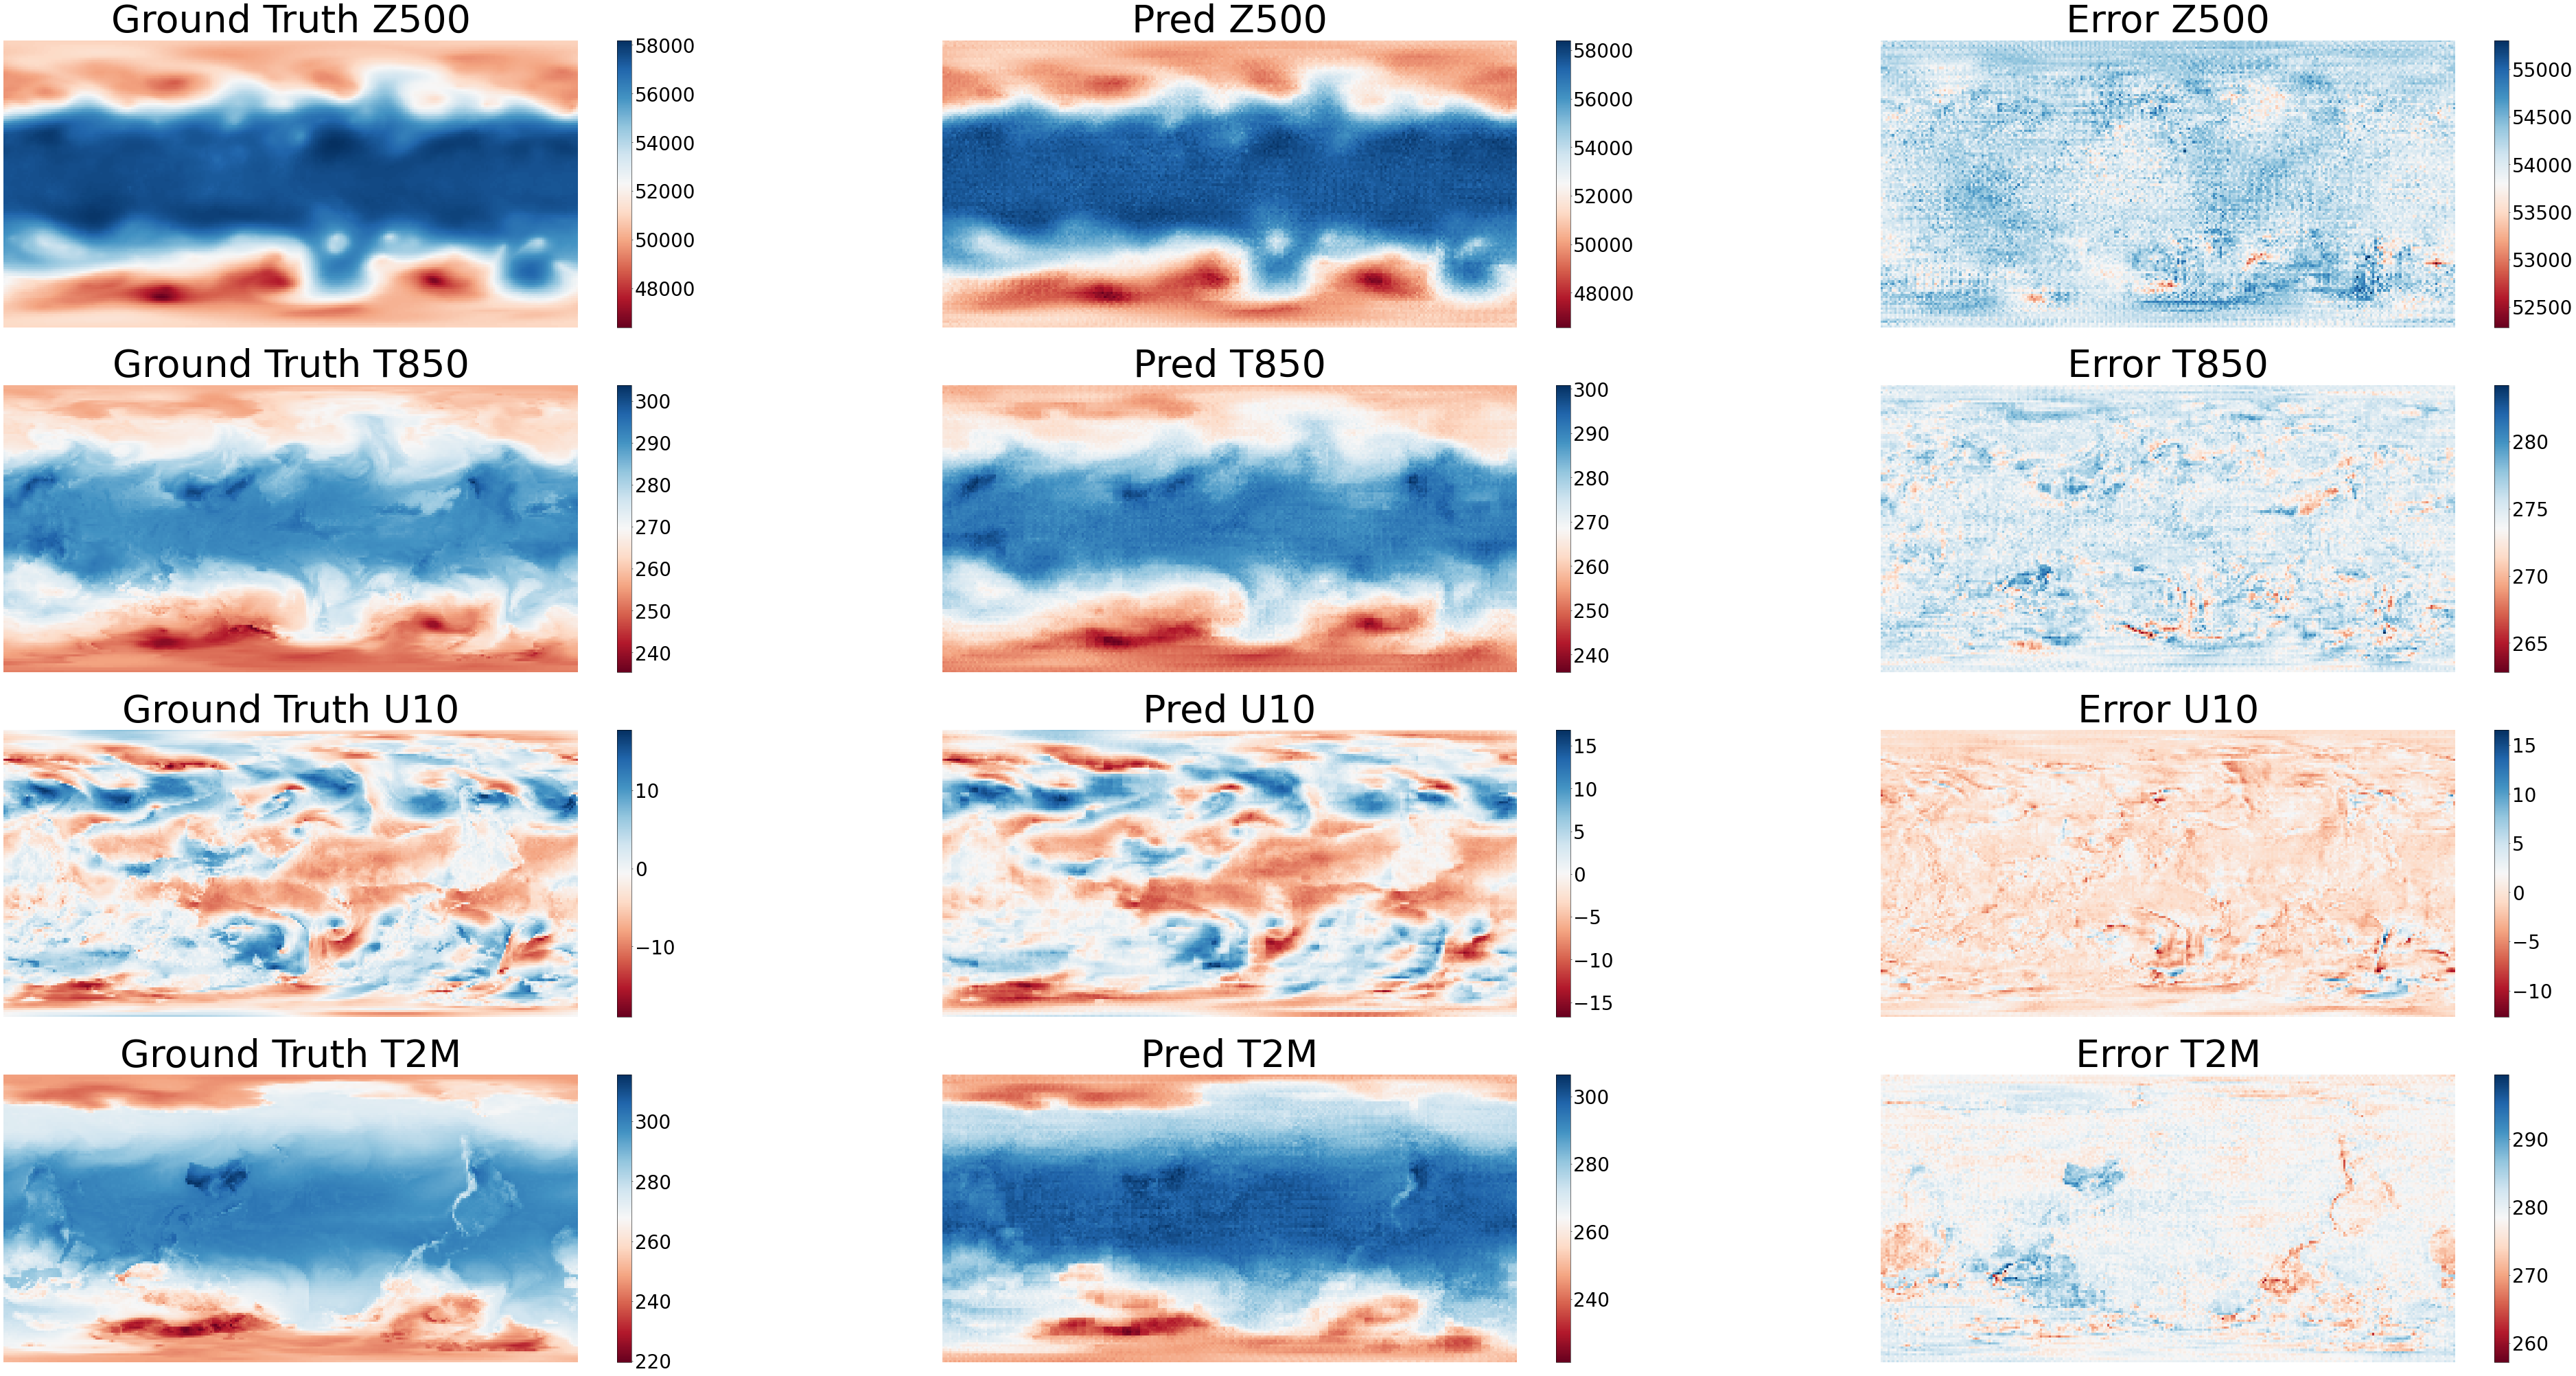

In [46]:
test_dataset_generator = Era5Data(data_params=config["data"], run_mode='test')
test_dataset = Dataset(test_dataset_generator, distribute=False,
                       num_workers=config["data"]['num_workers'], shuffle=False)
test_dataset = test_dataset.create_dataset(config["data"]['batch_size'])
data = next(test_dataset.create_dict_iterator())
inputs = data['inputs']
labels = data['labels']
pred_time_index = 0
pred = inference_module.forecast(inputs)
pred = pred[pred_time_index].asnumpy()
ground_truth = labels[..., pred_time_index, :, :].asnumpy()
plt_data(pred, ground_truth, config['data']['root_dir'])